In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import re

In [5]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

anos = [2024, 2022, 2020, 2018, 2016, 2014, 2012]

tabelas = []

for ano in anos:
    link = f"https://understat.com/league/EPL/{ano}"
    
    res = requests.get(link)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find_all('script')
    
    strings = scripts[2].string 
    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')
    
    data = json.loads(json_data)

    df = pd.DataFrame(data.values())
    df = df.explode("history")
    h = df.pop("history")
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(h.tolist())], axis=1)
    df = df.infer_objects()

    table = df.groupby(['title']).agg({
        'wins': 'sum', 
        'draws': 'sum', 
        'loses': 'sum', 
        'scored': 'sum', 
        'missed': 'sum', 
        'pts': 'sum', 
        'xG': 'sum', 
        'xGA': 'sum', 
        'xpts': 'sum', 
        'npxG': 'sum', 
        'npxGA': 'sum', 
        'deep': 'sum', 
        'deep_allowed': 'sum'
    }).reset_index()
    
    tabelas.append(table)

for i, tabela in enumerate(tabelas):
    print(f"Tabela da temporada {anos[i]}:")
    tabela = pd.DataFrame(tabela)
    print(tabela.sort_values(by='pts', ascending=False))
    print("\n")

Tabela da temporada 2024:
                      title  wins  draws  loses  scored  missed  pts  \
12          Manchester City    28      7      3      96      34   91   
0                   Arsenal    28      5      5      91      29   89   
10                Liverpool    24     10      4      86      41   82   
1               Aston Villa    20      8     10      76      61   68   
17                Tottenham    20      6     12      74      61   66   
6                   Chelsea    18      9     11      77      63   63   
13        Manchester United    18      6     14      57      58   60   
14         Newcastle United    18      6     14      85      62   60   
18                 West Ham    14     10     14      60      74   52   
7            Crystal Palace    13     10     15      57      58   49   
8                   Everton    13      9     16      40      51   48   
4                  Brighton    12     12     14      55      62   48   
2               Bournemouth    13     

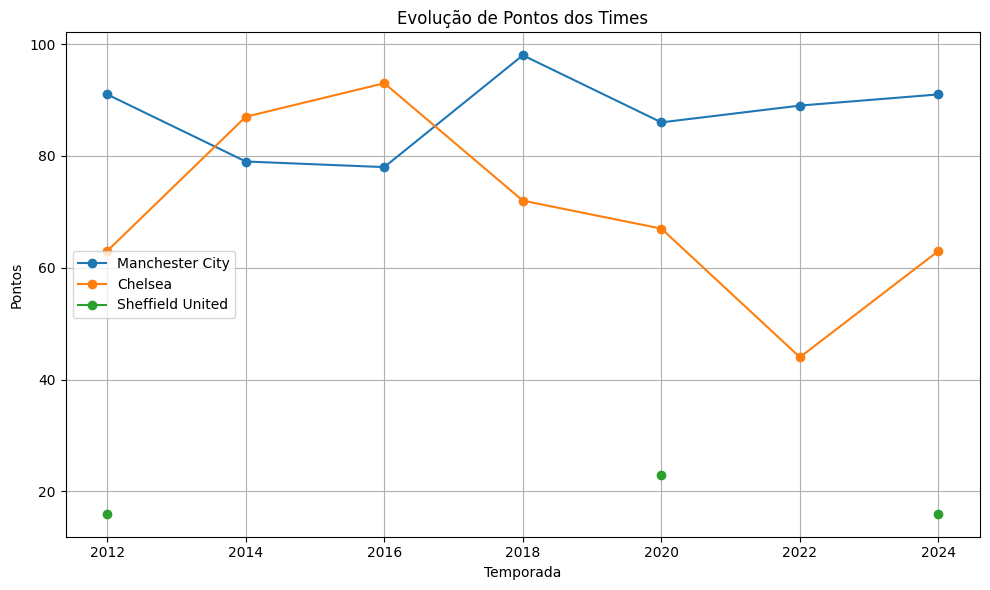

In [6]:
import matplotlib.pyplot as plt

times = ["Manchester City", "Chelsea", "Sheffield United"]

pontos_por_time = {time: [] for time in times}

for tabela in tabelas:
    for time in times:
        dados_time = tabela[tabela['title'] == time]
        if not dados_time.empty:
            pontos_time = dados_time['pts'].values[0]
            pontos_por_time[time].append(pontos_time)
        else:
            pontos_por_time[time].append(None)

plt.figure(figsize=(10, 6))

for time in times:
    plt.plot(anos, pontos_por_time[time], marker='o', linestyle='-', label=f'{time}')

plt.title('Evolução de Pontos dos Times')
plt.xlabel('Temporada')
plt.ylabel('Pontos')
plt.xticks(anos)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


Informações dos Clusters:
Cluster 0:
xG     63.614260
xGA    56.039251
pts    59.906977
Name: 0, dtype: float64

Cluster 1:
xG     44.485915
xGA    55.144058
pts    43.163265
Name: 1, dtype: float64

Cluster 2:
xG     43.320590
xGA    73.561708
pts    32.080000
Name: 2, dtype: float64

Cluster 3:
xG     77.049244
xGA    35.633956
pts    82.826087
Name: 3, dtype: float64



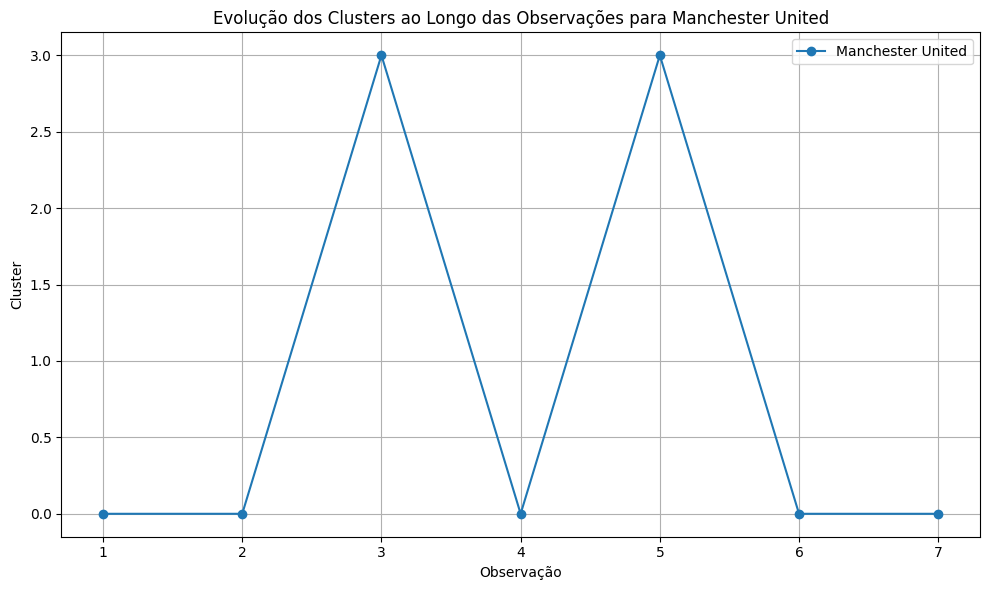

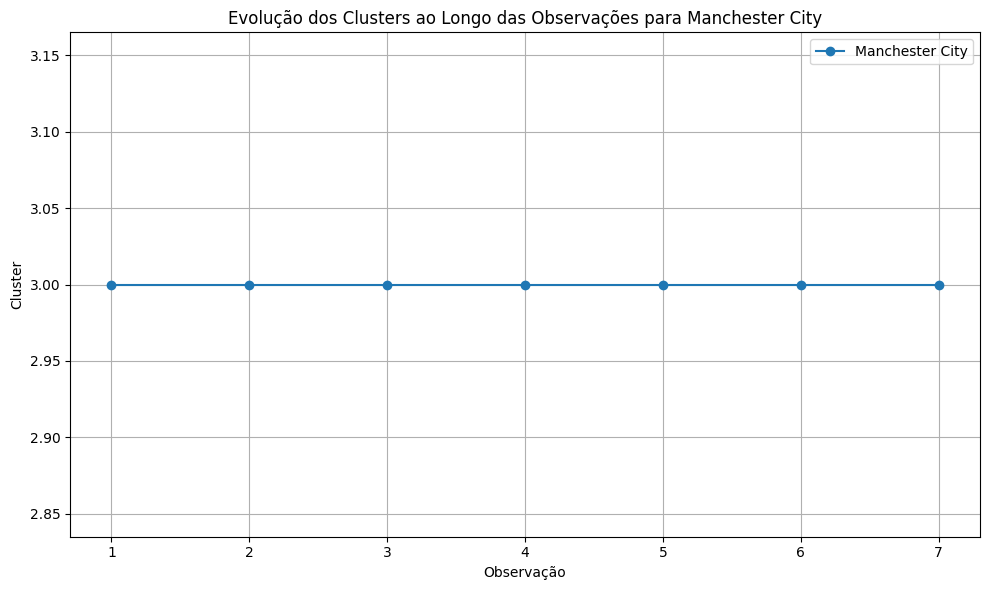

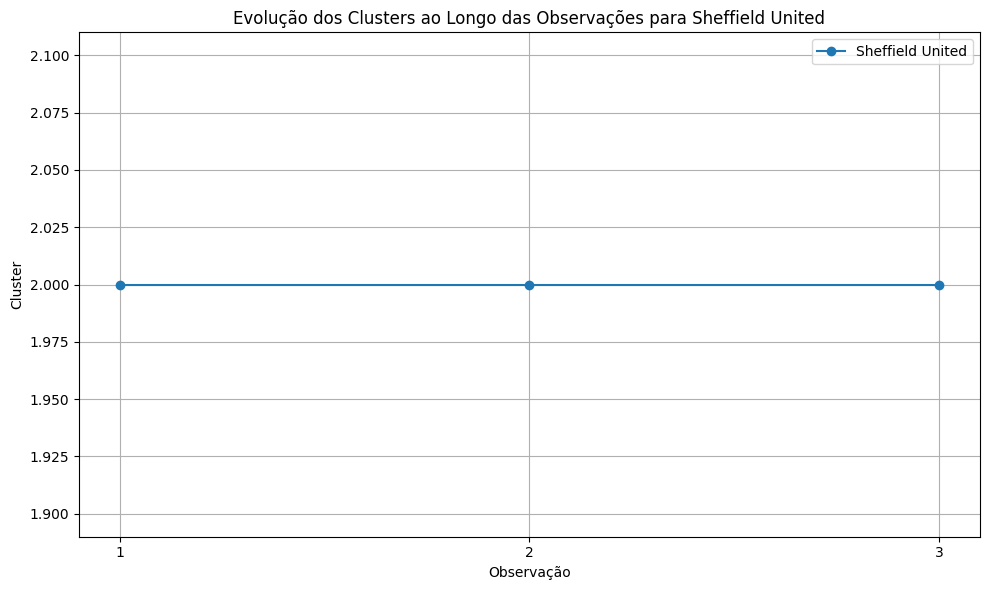

In [9]:
features = ['xG', 'xGA', 'pts']

df_concat = pd.concat(tabelas)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_concat[features])

kmeans = KMeans(n_clusters=4, random_state=0)
df_concat['cluster'] = kmeans.fit_predict(df_scaled)

#agrupar por time e cluster para ver a evolução ao longo do tempo
time_clusters = df_concat.groupby('title')['cluster'].apply(list)

#imprimir informações de cada cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Desescala os centróides
cluster_info = pd.DataFrame(cluster_centers, columns=features)

print("Informações dos Clusters:")
for i, cluster_info_row in cluster_info.iterrows():
    print(f"Cluster {i}:")
    print(cluster_info_row)
    print()

# Visualizar a evolução dos clusters para alguns times específicos
times_especificos = ['Manchester United', 'Manchester City', 'Sheffield United']
for time in times_especificos:
    clusters = time_clusters[time]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(clusters) + 1), clusters, marker='o', linestyle='-', label=time)
    plt.title(f'Evolução dos Clusters ao Longo das Observações para {time}')
    plt.xlabel('Observação')
    plt.ylabel('Cluster')
    plt.xticks(range(1, len(clusters) + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
cluster_team_counts = df_concat.groupby(['cluster', 'title']).size().reset_index(name='count')

cluster_team_counts_sorted = cluster_team_counts.sort_values(by=['cluster', 'count'], ascending=[True, False])

print("Times que mais aparecem em cada cluster:")
for cluster_num in range(4):
    print(f"Cluster {cluster_num}:")
    top_teams = cluster_team_counts_sorted.loc[cluster_team_counts_sorted['cluster'] == cluster_num].head()['title'].tolist()
    print(top_teams)
    print()

Times que mais aparecem em cada cluster:
Cluster 0:
['Tottenham', 'Manchester United', 'Aston Villa', 'Everton', 'Arsenal']

Cluster 1:
['Crystal Palace', 'Leicester', 'West Ham', 'Burnley', 'Fulham']

Cluster 2:
['Burnley', 'Sheffield United', 'Fulham', 'Luton', 'West Ham']

Cluster 3:
['Manchester City', 'Arsenal', 'Chelsea', 'Liverpool', 'Manchester United']



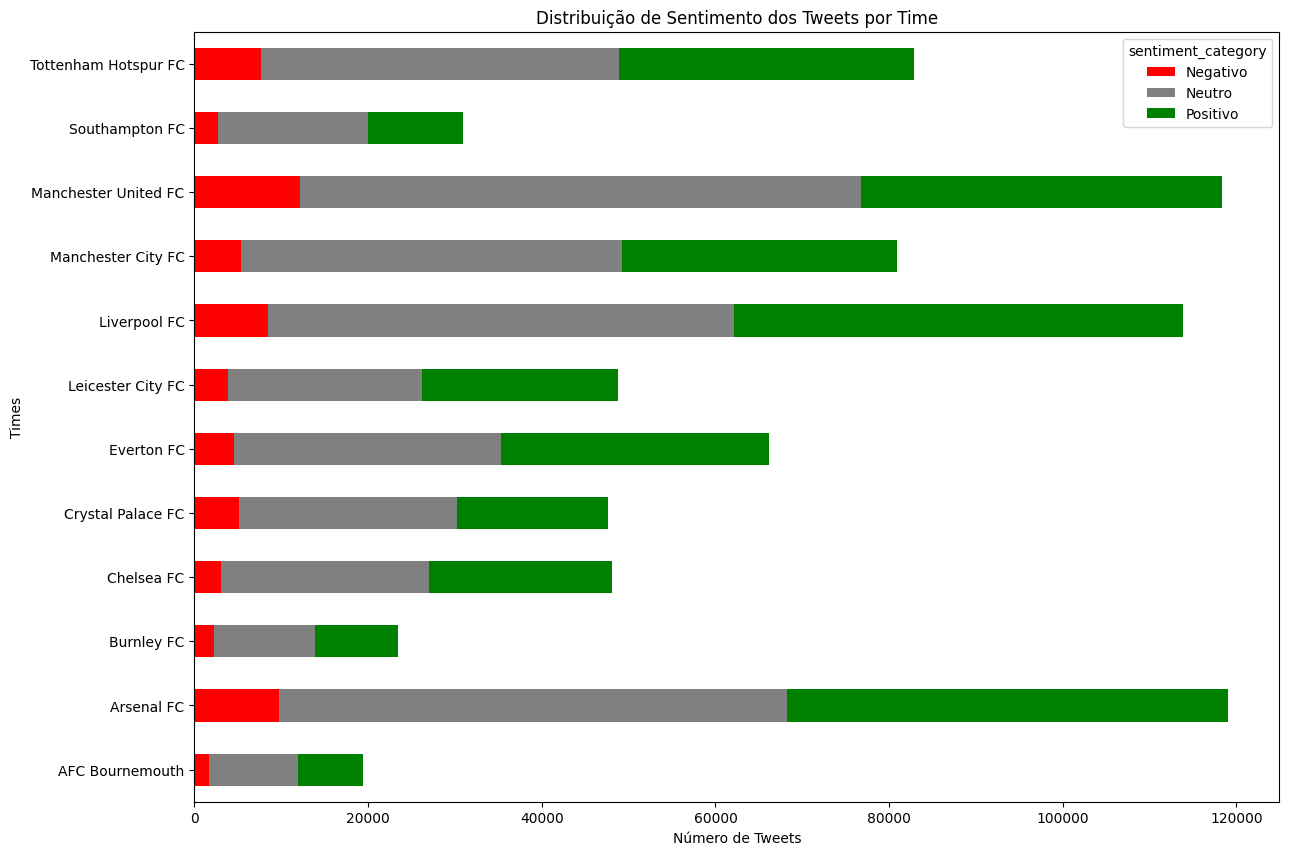

In [11]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

tweets_df = pd.read_csv('tweets.csv')

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

tweets_df['calculated_polarity'] = tweets_df['text'].apply(get_polarity)

def categorize_polarity(polarity):
    if polarity < -0.1:
        return 'Negativo'
    elif polarity > 0.1:
        return 'Positivo'
    else:
        return 'Neutro'

tweets_df['sentiment_category'] = tweets_df['calculated_polarity'].apply(categorize_polarity)

team_sentiment = tweets_df.groupby(['group_name', 'sentiment_category']).size().unstack(fill_value=0)

team_sentiment.plot(kind='barh', stacked=True, figsize=(14, 10), color=['red', 'gray', 'green'])
plt.xlabel('Número de Tweets')
plt.ylabel('Times')
plt.title('Distribuição de Sentimento dos Tweets por Time')
plt.show()


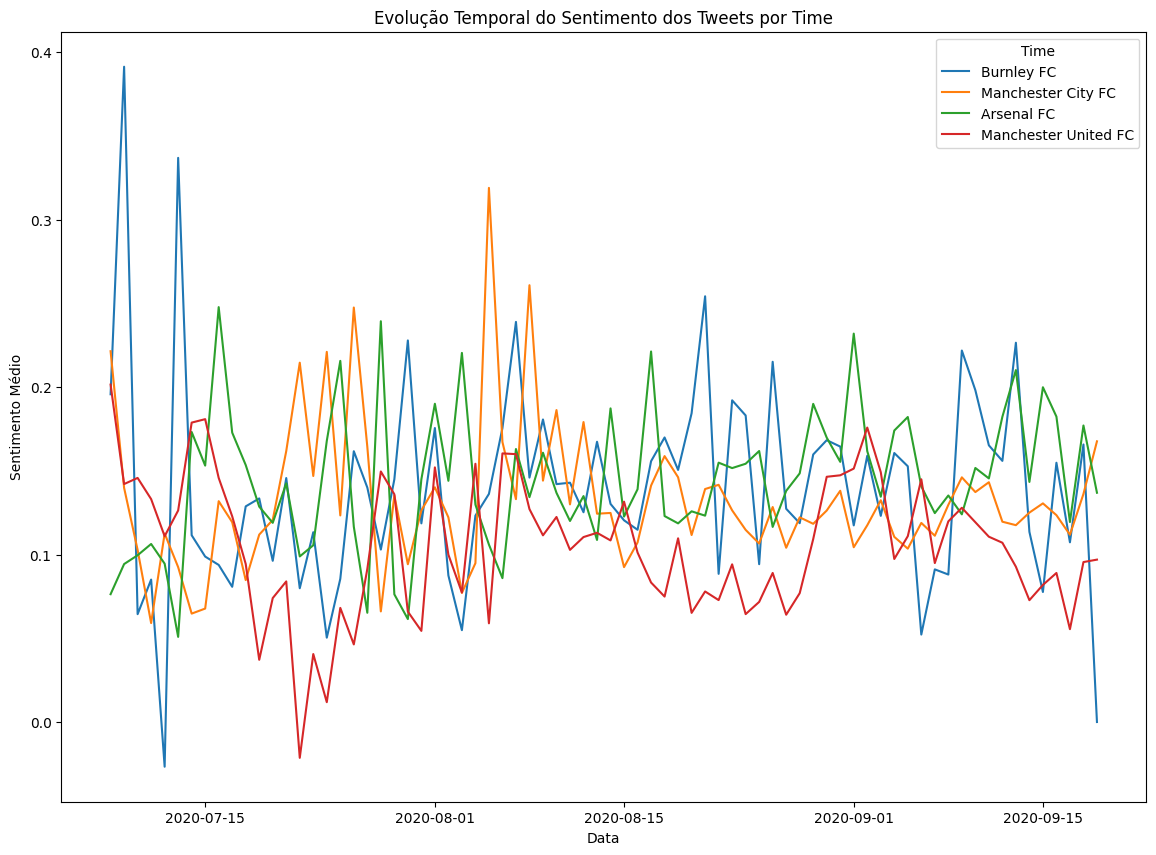

In [12]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

time_series = tweets_df.set_index('created_at').groupby('group_name')['calculated_polarity'].resample('D').mean().unstack('group_name')

filtered_teams = ['Burnley FC', 'Manchester City FC', 'Arsenal FC', 'Manchester United FC']
plt.figure(figsize=(14, 10))
for team in filtered_teams:
    if team in time_series.columns:
        plt.plot(time_series.index, time_series[team], label=team)
plt.xlabel('Data')
plt.ylabel('Sentimento Médio')
plt.title('Evolução Temporal do Sentimento dos Tweets por Time')
plt.legend(title='Time')
plt.show()


In [32]:
game_ids = pd.DataFrame()  

for year in [2019, 2020]:
    url = f'https://understat.com/league/EPL/{year}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'lxml')
    scripts = soup.find_all('script')

    strings = scripts[1].string
    ind_start = strings.index("('") + 2

    ind_end = strings.index("')")
    json_data = strings[ind_start:ind_end]

    json_data = json_data.encode('utf8').decode('unicode_escape')
    data = json.loads(json_data)
    df = pd.DataFrame(data).sort_values('datetime')  

    df['id'] = df['id'].astype('int32')  
    game_ids = pd.concat([game_ids, df]) 

game_ids = game_ids.reset_index(drop=True) 
game_ids_list = game_ids['id'].tolist()  

print(game_ids_list)


[11643, 11644, 11645, 11646, 11647, 11648, 11649, 11650, 11651, 11652, 11653, 11658, 11657, 11654, 11655, 11656, 11659, 11660, 11661, 11662, 11663, 11664, 11669, 11667, 11665, 11666, 11670, 11671, 11668, 11672, 11673, 11678, 11679, 11677, 11676, 11675, 11674, 11680, 11681, 11682, 11683, 11686, 11687, 11684, 11685, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11698, 11699, 11700, 11697, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11711, 11710, 11712, 11713, 11714, 11715, 11717, 11719, 11720, 11716, 11718, 11722, 11721, 11727, 11732, 11731, 11728, 11723, 11724, 11725, 11726, 11729, 11730, 11740, 11737, 11741, 11742, 11734, 11735, 11738, 11733, 11736, 11739, 11745, 11752, 11749, 11750, 11744, 11743, 11746, 11751, 11747, 11748, 11757, 11754, 11753, 11756, 11758, 11759, 11762, 11761, 11760, 11755, 11772, 11763, 11765, 11766, 11767, 11768, 11771, 11769, 11770, 11764, 11777, 11773, 11774, 11776, 11779, 11778, 11780, 11781, 11775, 11782, 11791, 11784, 11785

In [33]:
match_stats = pd.DataFrame()

for i in tqdm(game_ids_list):
    try:
        response = requests.get(f'https://understat.com/match/{i}')
        response.raise_for_status()  
        match_info = re.search(r"match_info\s+=\s+JSON.parse\('([^']+)", response.text)
        if match_info:
            decoded_string = bytes(match_info.groups()[0], 'utf-8').decode('unicode_escape')
            matchObj = json.loads(decoded_string)
            sh = pd.Series(matchObj)
            match_stats = pd.concat([match_stats, pd.DataFrame(sh).T], ignore_index=True)
        else:
            print(f"Não foi possível encontrar informações para o jogo {i}")
    except requests.exceptions.RequestException as e:
        print(f"Erro ao tentar obter o jogo {i}: {e}")
    except json.JSONDecodeError as e:
        print(f"Erro ao decodificar JSON para o jogo {i}: {e}")

print(match_stats)  


100%|██████████| 760/760 [12:08<00:00,  1.04it/s]

        id      fid    h    a                 date league_id season h_goals  \
0    11643  1375927   87   79  2019-08-09 20:00:00         1   2019       4   
1    11644  1375928   81   88  2019-08-10 12:30:00         1   2019       0   
2    11645  1375929   73  238  2019-08-10 15:00:00         1   2019       1   
3    11646  1375930   92   74  2019-08-10 15:00:00         1   2019       3   
4    11647  1375931   78   72  2019-08-10 15:00:00         1   2019       0   
..     ...      ...  ...  ...                  ...       ...    ...     ...   
755  14810  1485559   87   78  2021-05-23 15:00:00         1   2020       2   
756  14811  1485560   88   72  2021-05-23 15:00:00         1   2020       5   
757  14812  1485561  238   92  2021-05-23 15:00:00         1   2020       1   
758  14813  1485562   81   74  2021-05-23 15:00:00         1   2020       3   
759  14814  1485563  229   89  2021-05-23 15:00:00         1   2020       1   

    a_goals                   team_h             te

In [34]:

man_united_matches = match_stats[(match_stats['team_h'] == 'Manchester United') | (match_stats['team_a'] == 'Manchester United')]

def get_result(row):
    if row['team_h'] == 'Manchester United':
        if row['h_goals'] > row['a_goals']:
            return 'Vitória'
        elif row['h_goals'] < row['a_goals']:
            return 'Derrota'
        else:
            return 'Empate'
    else:  #como time visitante
        if row['a_goals'] > row['h_goals']:
            return 'Vitória'
        elif row['a_goals'] < row['h_goals']:
            return 'Derrota'
        else:
            return 'Empate'

man_united_matches['resultado'] = man_united_matches.apply(get_result, axis=1)

man_united_matches_resultado = man_united_matches[['date', 'team_h', 'team_a', 'h_goals', 'a_goals', 'resultado']]

man_united_matches_resultado = man_united_matches_resultado.sort_values(by='date')
man_united_matches_resultado = pd.DataFrame(man_united_matches_resultado)
man_united_matches_resultado


/tmp/ipykernel_543308/3240006472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_united_matches['resultado'] = man_united_matches.apply(get_result, axis=1)


,date,team_h,team_a,h_goals,a_goals,resultado
9,2019-08-11 16:30:00,Manchester United,Chelsea,4,0,Vitória
19,2019-08-19 20:00:00,Wolverhampton Wanderers,Manchester United,1,1,Empate
22,2019-08-24 15:00:00,Manchester United,Crystal Palace,1,2,Derrota
30,2019-08-31 12:30:00,Southampton,Manchester United,1,1,Empate
43,2019-09-14 14:00:00,Manchester United,Leicester,1,0,Vitória
56,2019-09-22 13:00:00,West Ham,Manchester United,2,0,Derrota
69,2019-09-30 19:00:00,Manchester United,Arsenal,1,1,Empate
79,2019-10-06 16:30:00,Newcastle United,Manchester United,1,0,Derrota
88,2019-10-20 16:30:00,Manchester United,Liverpool,1,1,Empate
99,2019-10-27 16:30:00,Norwich,Manchester United,1,3,Vitória


In [37]:
#filtrar os jogos onde o Manchester United perdeu em casa
derrotas_em_casa = man_united_matches_resultado[
    (man_united_matches_resultado['team_h'] == 'Manchester United') & 
    (man_united_matches_resultado['resultado'] == 'Derrota')
]

#contar as derrotas em casa
quantidade_derrotas_em_casa = len(derrotas_em_casa)

#mostrar os times para quem o Manchester United perdeu em casa
times_derrotaram_em_casa = derrotas_em_casa['team_a'].value_counts()

print(f'Quantidade de derrotas em casa: {quantidade_derrotas_em_casa}')
print('Times que derrotaram o Manchester United em casa:')
print(times_derrotaram_em_casa)


#filtrar os jogos onde o Manchester United perdeu fora de casa
derrotas_fora_de_casa = man_united_matches_resultado[
    (man_united_matches_resultado['team_a'] == 'Manchester United') & 
    (man_united_matches_resultado['resultado'] == 'Derrota')
]

#contar as derrotas fora de casa
quantidade_derrotas_fora_de_casa = len(derrotas_fora_de_casa)

#mostrar os times para quem o Manchester United perdeu fora de casa
times_derrotaram_fora = derrotas_fora_de_casa['team_h'].value_counts()

print(f'\nQuantidade de derrotas fora de casa: {quantidade_derrotas_fora_de_casa}')
print('Times que derrotaram o Manchester United fora de casa:')
print(times_derrotaram_fora)


Quantidade de derrotas em casa: 8
Times que derrotaram o Manchester United em casa:
team_a
Crystal Palace      2
Burnley             1
Tottenham           1
Arsenal             1
Sheffield United    1
Leicester           1
Liverpool           1
Name: count, dtype: int64

Quantidade de derrotas fora de casa: 6
Times que derrotaram o Manchester United fora de casa:
team_h
West Ham            1
Newcastle United    1
Bournemouth         1
Watford             1
Arsenal             1
Liverpool           1
Name: count, dtype: int64
